## Analyse FF Mouse Brain Coronal Section with scanpy then identification of SVGs with SpatialDE

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
#import scanorama
import csv
from sklearn.metrics.pairwise import cosine_distances

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)


%load_ext autoreload
%autoreload 2

In [2]:
#load in dataset
ff_mouse_brain_coronal = sc.read_visium('ff_mouse_brain_coronal_section',count_file='V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.h5')
ff_mouse_brain_coronal.var_names_make_unique()

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
#Calculate some QC metrics for the data
ff_mouse_brain_coronal.var["mt"] = ff_mouse_brain_coronal.var_names.str.startswith("mt")
sc.pp.calculate_qc_metrics(ff_mouse_brain_coronal, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


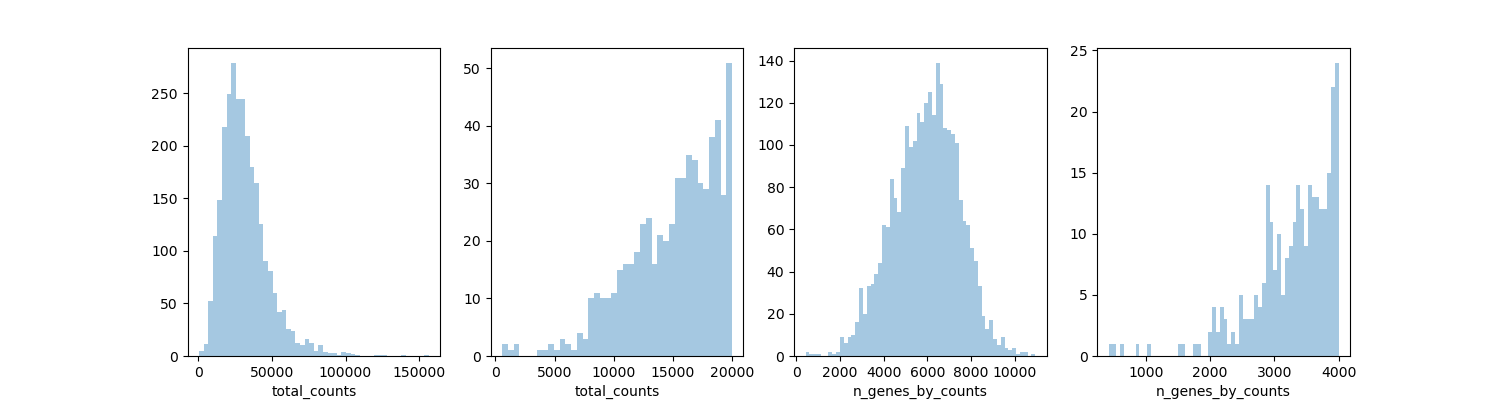

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


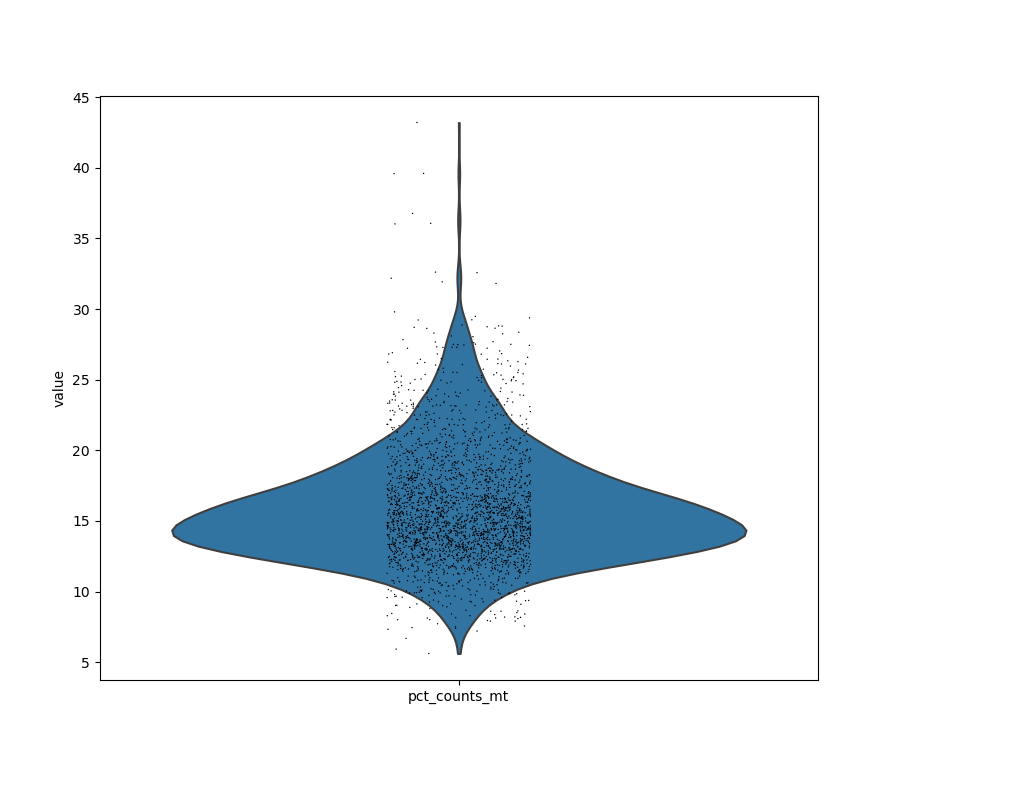

In [4]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ff_mouse_brain_coronal.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_mouse_brain_coronal.obs["total_counts"][ff_mouse_brain_coronal.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ff_mouse_brain_coronal.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ff_mouse_brain_coronal.obs["n_genes_by_counts"][ff_mouse_brain_coronal.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ff_mouse_brain_coronal,['pct_counts_mt'])

In [5]:
ff_mouse_brain_coronal

AnnData object with n_obs × n_vars = 2702 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
#Perform some filtering
sc.pp.filter_cells(ff_mouse_brain_coronal, min_counts=10000)
print(f'Number of cells after min count filter: {ff_mouse_brain_coronal.n_obs}')
sc.pp.filter_cells(ff_mouse_brain_coronal, max_counts=80000)
print(f'Number of cells after max count filter: {ff_mouse_brain_coronal.n_obs}')
ff_mouse_brain_coronal = ff_mouse_brain_coronal[ff_mouse_brain_coronal.obs["pct_counts_mt"] < 25]
ff_mouse_brain_coronal = ff_mouse_brain_coronal[ff_mouse_brain_coronal.obs["pct_counts_mt"] >= 5]
print(f"#cells after MT filter: {ff_mouse_brain_coronal.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ff_mouse_brain_coronal, min_cells=10)
print(f'Number of genes after cell filter: {ff_mouse_brain_coronal.n_vars}')
sc.pp.filter_cells(ff_mouse_brain_coronal, min_genes = 3000)
print(f'Number of cells after gene filter: {ff_mouse_brain_coronal.n_obs}')

Number of cells after min count filter: 2634
Number of cells after max count filter: 2594
#cells after MT filter: 2523


/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of genes after cell filter: 17422
Number of cells after gene filter: 2513


In [7]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ff_mouse_brain_coronal, inplace=True)
sc.pp.log1p(ff_mouse_brain_coronal)
sc.pp.highly_variable_genes(ff_mouse_brain_coronal, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


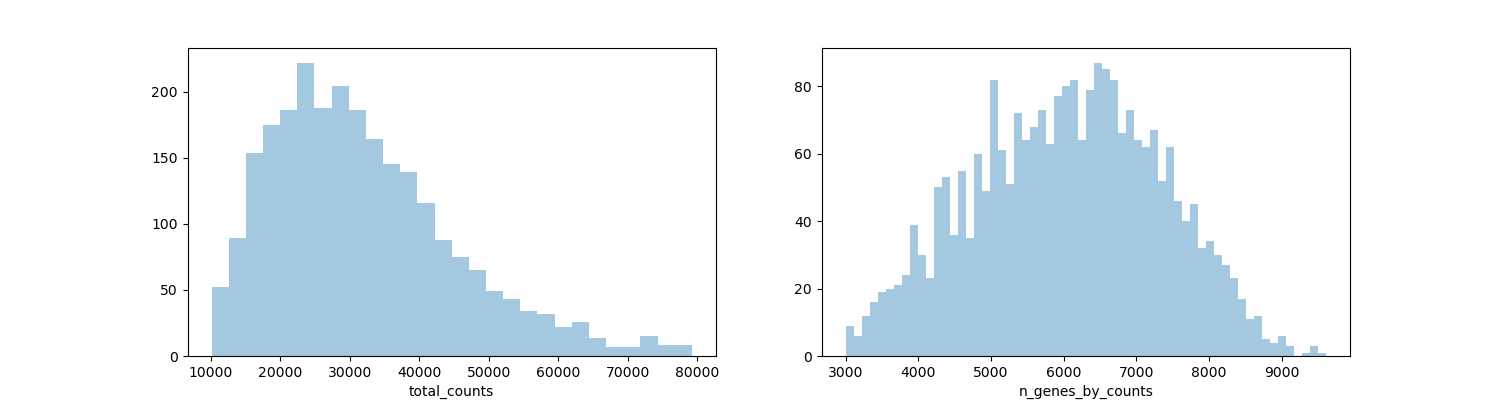

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

In [8]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ff_mouse_brain_coronal.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_mouse_brain_coronal.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [9]:
#Perform next steps in cluster identification
sc.pp.pca(ff_mouse_brain_coronal,n_comps=20)
sc.pp.neighbors(ff_mouse_brain_coronal)
sc.tl.umap(ff_mouse_brain_coronal)
sc.tl.leiden(ff_mouse_brain_coronal, key_added='clusters')

<IPython.core.display.Javascript object>


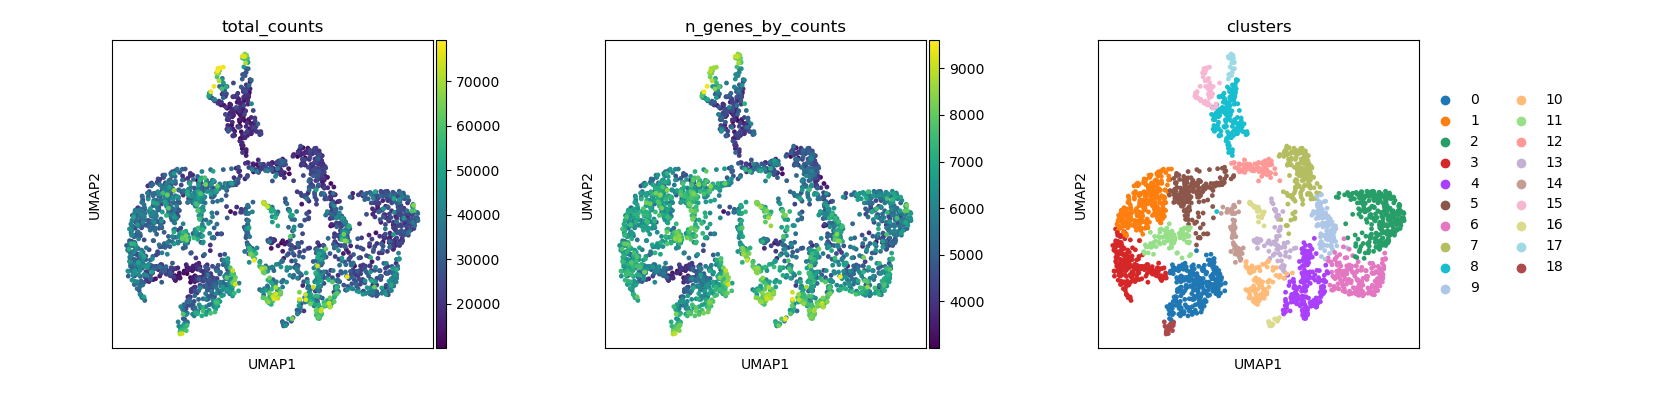

In [10]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ff_mouse_brain_coronal, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


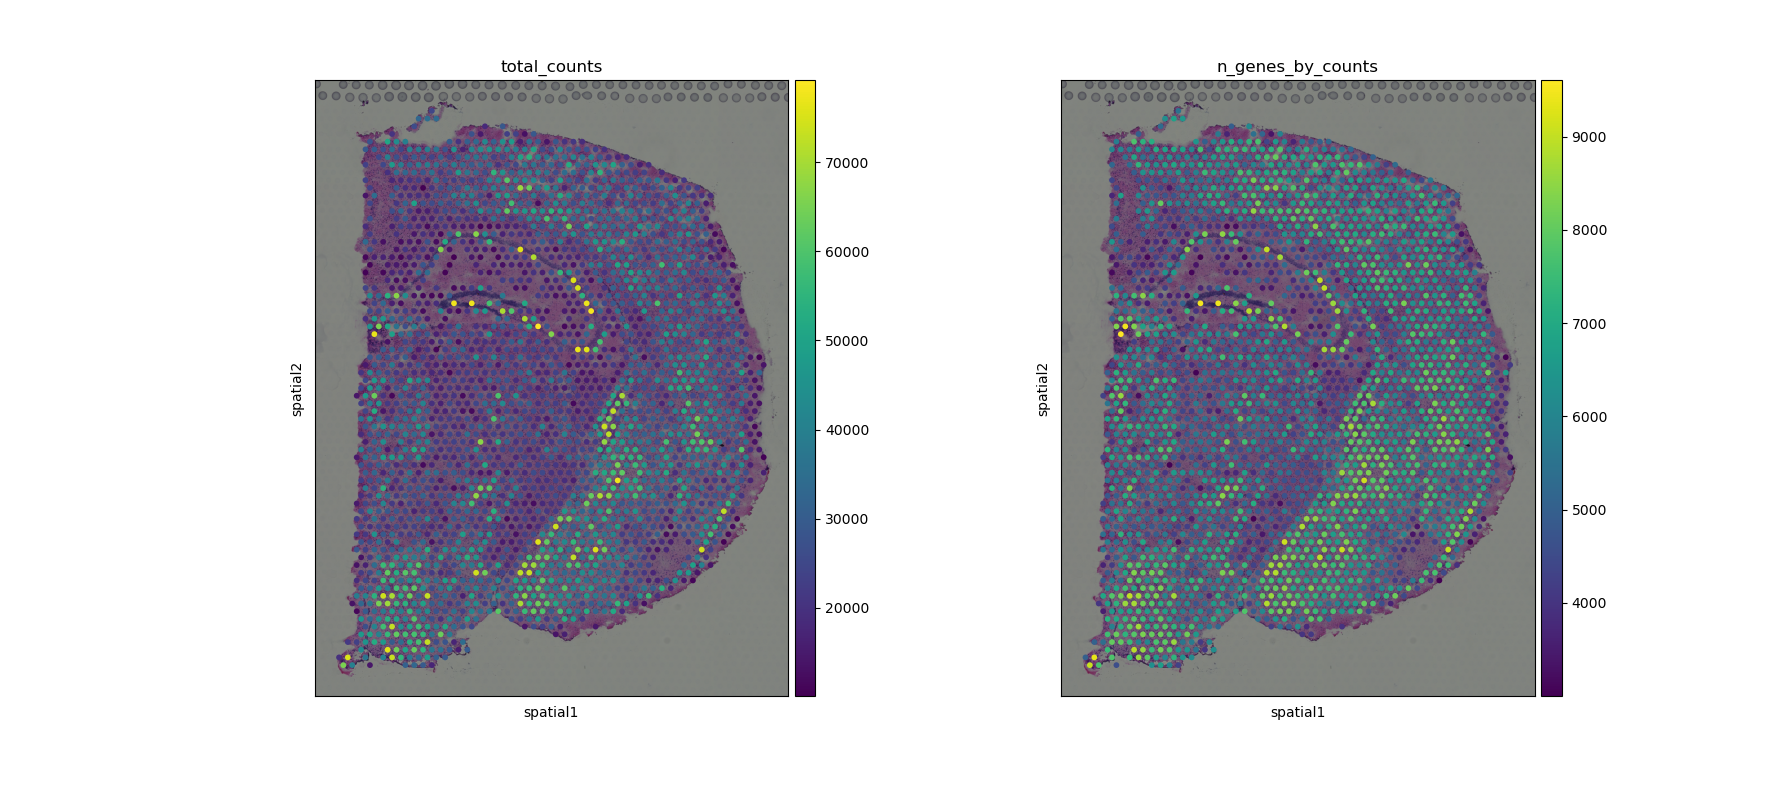

In [11]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ff_mouse_brain_coronal, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


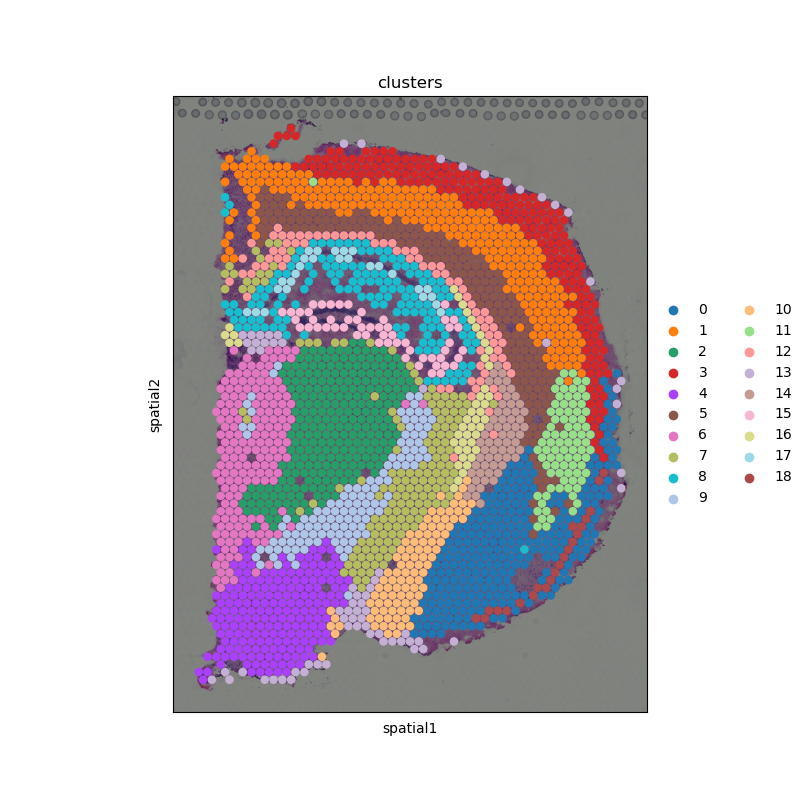

In [12]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(ff_mouse_brain_coronal, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


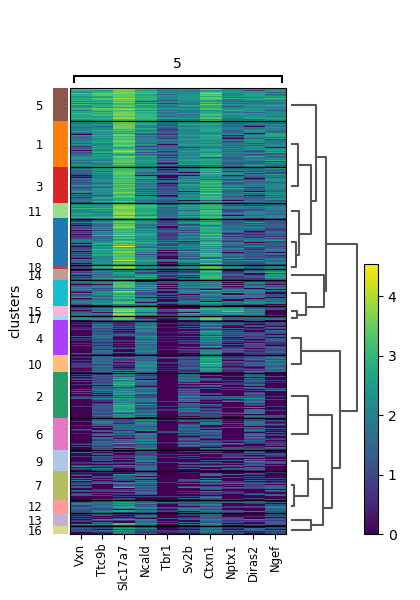

In [13]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(ff_mouse_brain_coronal, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(ff_mouse_brain_coronal, groups="5", n_genes=10, groupby="clusters")

### Write out processed files

In [ ]:
##write this AnnData object to a didfferent file format
ff_mouse_brain_coronal.write_h5ad(filename='ff_mouse_brain_coronal.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [ ]:
#Write out normalised dataframe with expression values to file so it can be read back in for this purpose
ff_mouse_brain_coronal.write_csvs('preprocessed_output/',skip_data=False)

### Identify SVGs with SpatialDE

In [14]:
%%time
#Now try and find SVGs with SpatialDE
#We need to convert normalised counts into a DF for spatial DE

counts = pd.DataFrame(ff_mouse_brain_coronal.X.todense(), columns=ff_mouse_brain_coronal.var_names, index=ff_mouse_brain_coronal.obs_names)
coord = pd.DataFrame(ff_mouse_brain_coronal.obsm['spatial'], columns=['x_coord', 'y_coord'], index=ff_mouse_brain_coronal.obs_names)
results = SpatialDE.run(coord, counts)

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
 15%|██████████▊                                                            | 2647/17422 [00:13<01:15, 196.89it/s]


 31%|██████████████████████▏                                                | 5446/17422 [00:28<01:00, 197.80it/s]


 47%|█████████████████████████████████▍                                     | 8216/17422 [00:43<00:50, 180.66it/s]


 62%|███████████████████████████████████████████▏                          | 10757/17422 [00:58<00:40, 165.88it/s]


 77%|█████████████████████████████████████████████████████▊                | 13404/17422 [01:13<00:23, 174.59it/s]


 92%|████████████████████████████████████████████████████████████████▍     | 16024/17422 [01:28<00:07, 175.54it/s]


 10%|██████▊                                                                | 1662/17422 [00:06<01:02, 250.69it/s]


 30%|█████████████████████▌                                                 | 5292/17422 [00:20<00:47, 257.02it/s]


 51%|████████████████████████████████████▍                                  | 8926/17422 [00:35<00:34, 243.15it/s]


 72%|██████████████████████████████████████████████████▏                   | 12496/17422 [00:49<00:19, 253.15it/s]


 92%|████████████████████████████████████████████████████████████████▌     | 16082/17422 [01:04<00:05, 242.94it/s]


 12%|████████▊                                                              | 2165/17422 [00:08<00:59, 255.59it/s]


 33%|███████████████████████▌                                               | 5780/17422 [00:23<00:46, 251.82it/s]


 54%|██████████████████████████████████████▏                                | 9365/17422 [00:37<00:34, 234.95it/s]


 74%|████████████████████████████████████████████████████                  | 12951/17422 [00:51<00:17, 253.11it/s]


 95%|██████████████████████████████████████████████████████████████████▎   | 16494/17422 [01:06<00:04, 216.28it/s]


 15%|██████████▎                                                            | 2542/17422 [00:10<00:59, 251.46it/s]


 35%|████████████████████████▊                                              | 6095/17422 [00:24<00:46, 246.22it/s]


 55%|███████████████████████████████████████▏                               | 9625/17422 [00:39<00:32, 242.64it/s]


 75%|████████████████████████████████████████████████████▋                 | 13125/17422 [00:53<00:17, 250.99it/s]


 96%|██████████████████████████████████████████████████████████████████▉   | 16665/17422 [01:08<00:03, 252.30it/s]


 14%|██████████▏                                                            | 2489/17422 [00:11<01:07, 219.67it/s]


 33%|███████████████████████▋                                               | 5798/17422 [00:26<00:53, 217.89it/s]


 52%|█████████████████████████████████████▏                                 | 9112/17422 [00:40<00:36, 229.62it/s]


 70%|█████████████████████████████████████████████████                     | 12210/17422 [00:55<00:24, 214.09it/s]


 89%|██████████████████████████████████████████████████████████████▏       | 15470/17422 [01:10<00:08, 218.35it/s]


  6%|████                                                                    | 995/17422 [00:05<01:29, 183.14it/s]


 20%|██████████████▌                                                        | 3570/17422 [00:20<01:22, 167.74it/s]


 35%|████████████████████████▉                                              | 6122/17422 [00:34<01:02, 180.46it/s]


 49%|███████████████████████████████████                                    | 8610/17422 [00:51<00:54, 162.43it/s]


 64%|█████████████████████████████████████████████                         | 11223/17422 [01:06<00:34, 179.21it/s]


 79%|███████████████████████████████████████████████████████▎              | 13776/17422 [01:20<00:20, 180.99it/s]


 94%|█████████████████████████████████████████████████████████████████▌    | 16333/17422 [01:35<00:06, 172.88it/s]


 10%|███████▎                                                               | 1792/17422 [00:08<01:08, 226.95it/s]


 29%|████████████████████▎                                                  | 4988/17422 [00:22<00:59, 210.39it/s]


 47%|█████████████████████████████████▎                                     | 8170/17422 [00:36<00:40, 227.31it/s]


 65%|█████████████████████████████████████████████▌                        | 11335/17422 [00:51<00:28, 216.84it/s]


 83%|██████████████████████████████████████████████████████████▎           | 14527/17422 [01:05<00:12, 231.67it/s]


  1%|▊                                                                       | 204/17422 [00:01<01:19, 215.44it/s]


 19%|█████████████▌                                                         | 3315/17422 [00:15<01:15, 187.36it/s]


 37%|██████████████████████████▏                                            | 6441/17422 [00:30<00:51, 211.24it/s]


 55%|███████████████████████████████████████                                | 9594/17422 [00:44<00:36, 213.29it/s]


 73%|███████████████████████████████████████████████████                   | 12712/17422 [00:58<00:21, 220.93it/s]


 91%|███████████████████████████████████████████████████████████████▌      | 15834/17422 [01:13<00:07, 203.13it/s]


  9%|██████                                                                 | 1490/17422 [00:06<01:10, 224.61it/s]


 27%|███████████████████                                                    | 4668/17422 [00:21<00:57, 220.50it/s]


 45%|████████████████████████████████▎                                       | 7821/17422 [00:36<01:59, 80.56it/s]


 63%|████████████████████████████████████████████                          | 10974/17422 [00:50<00:29, 218.16it/s]


 81%|████████████████████████████████████████████████████████▊             | 14144/17422 [01:05<00:14, 223.35it/s]


 99%|█████████████████████████████████████████████████████████████████████▌| 17308/17422 [01:19<00:00, 212.62it/s]


 17%|███████████▉                                                           | 2936/17422 [00:13<01:06, 216.41it/s]


 35%|████████████████████████▋                                              | 6069/17422 [00:28<00:51, 218.57it/s]


 53%|█████████████████████████████████████▍                                 | 9176/17422 [00:42<00:37, 218.96it/s]


 71%|█████████████████████████████████████████████████▍                    | 12294/17422 [00:56<00:24, 213.15it/s]


 88%|█████████████████████████████████████████████████████████████▊        | 15390/17422 [01:11<00:09, 211.07it/s]


Models: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [13:29<00:00, 80.96s/it]


CPU times: user 1h 22min 55s, sys: 12min 53s, total: 1h 35min 48s
Wall time: 14min 5s


In [ ]:
#Sort results for all qvals >= 0.05 and add them to file
results_filtered = results[results["qval"] <= 0.05]
results_filtered = results_filtered.sort_values(by="qval")
results_filtered.to_csv('ff_mouse_brain_coronal_svgs_spatialde.csv')
results_filtered